TODO:
* Compute power spectrum directly [FFT->CC], and using Wiener-Kinchin [AutoCorr->FFT]. Confirm they are the same
* Compute power spectrum using standard tools, confirm it is the same as above
* Plot AutoCorr and Power Spectrum for several deterministic and random functions
* Is there a finite-time-interval version of Autocorr, FFT, and Power spectrum? What do they mean?

**IMPORTANT NOTE**: All quantities that we actually calculate are estimators, because
1. All measures are either defined for infinite length sequences
2. Or are defined for ensemble average, whereas we calculate them for a single trial.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
%matplotlib inline

For any finite sequence $x_i, i \in [1..N]$ we can define the following temporal and spectral properties

<table>
    <tr>
        <th>Name</th>
        <th> ------------------Continuous--------- </th>
        <th> ----------Discrete----------- </th>
        <th>Description</th>
    </tr>
    <tr>
        <td> Fourier Transform </td>
        <td> $F(\omega) = \frac{1}{\sqrt{T}}\int_{0}^T f(t)e^{i\omega t} dt$ </td>
        <td> $\tilde{x}_i = \sum_{j=1}^{N} x_j e^{\frac{2 \pi \mathcal{I}}{N}ij}$ </td>
        <td></td>
    </tr>
    <tr>
        <td>Autocorrelation</td>
        <td> $A(t) = \lim_{T\rightarrow \infty}\frac{1}{T} \int_{\tau = 0}^{T-t} f(\tau) f(\tau + t) d\tau$ </td>
        <td> $a_i = \frac{1}{n} \sum_{j=1}^{n-i} x_j x_{j+i}$ </td>
        <td></td>
    </tr>
    <tr>
        <td> Periodigram </td>
        <td> </td>
        <td> </td>
        <td></td>
    </tr>
</table>

### Wiener-Khinchin Theorem

PSD
$S(\omega) 
  = |F(\omega)|^2
  = \frac{1}{T} \int_{0}^T \int_{0}^T f(t_1) f(t_2) e^{i\omega (t_2 - t_1)} dt_1 dt_2
  = \frac{1}{T} \int_{0}^T \int_{-t_1}^{T-t_1} f(t_1) f(t_1 + \tau) e^{i\omega \tau} dt_1 d\tau
$

## Part 1: Sanity Checks

Check that Numpy/Scipy functions provide the same results as naive functions. We will of course switch to standard functions later, as they are much faster. It is important though that we are well aware what they actually do

In [30]:
def homebrew_crosscorr(arr):
    N = arr.shape[0]
    rez = np.zeros(2*N-1)
    for i in range(-N,N-1):
        rez[N+i] = np.dot(arr[max(0, i+1): i+N+1], arr[max(0, -i-1): N-i-1])
    return rez

data = np.random.uniform(0,1,100)
data = np.array([np.sum(data[0:i]) for i in range(100)])

corr1 = homebrew_crosscorr(data)
corr2 = np.correlate(data, data, mode="full")

print("Testing cross-correlation: Total discrepancy", np.linalg.norm(corr1-corr2))

Testing cross-correlation: Total discrepancy 0.0


In [39]:
def homebrew_dft(arr):
    N = arr.shape[0]
    mat = np.zeros((N, N), dtype=complex)
    for i in range(N):
        for j in range(N):
            mat[i][j] = np.exp(-2*np.pi * 1j * i * j / N)
    
    return mat.dot(arr)

x = np.linspace(0, 1, 200)
y = np.sin(2 * np.pi * 10 * x)
dft1 = homebrew_dft(y)
dft2 = np.fft.fft(y)

print("Testing DFT: Total discrepancy", np.linalg.norm(dft1-dft2))

Testing DFT: Total discrepancy 4.517709679442738e-12


**FIXME**:
* Why mlab resamples?
* What is MLAB normalization convention for PSD?
* Why are there wiggles in homebrew PSD, but not in MLAB?
* Show Wiener-Khinchin by finding exact definition

Number of sample points for mlab PSD:  129
Maxima for FFT, WK, MLAB are  46725.067642579175 36795.1489931836 35724.18305867208


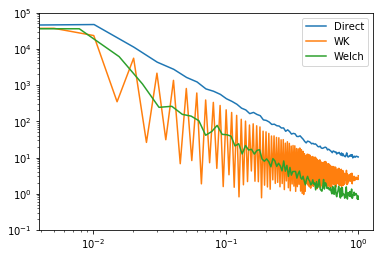

In [34]:
# PSD via ordinary definition
def homebrew_psd_direct(arr):
    N = len(arr)
    return np.abs(np.fft.fft(arr)[0:N//2])**2 / N

# PSD via Wiener-Khinchin
def homebrew_psd_wk(arr):
    N = len(arr)
    corr = np.correlate(arr, arr, mode='full') / (2*N-1)
    return np.abs(np.fft.fft(corr)[0:N])
#     corr = np.correlate(arr, arr, mode='full')[N-1:] / N
#     return np.abs(np.fft.fft(corr)[0:N//2])
                      
N_POINT = 200
# x = np.linspace(0, 1, N_POINT)
# y = np.sin(2 * np.pi * 10 * x)
y = np.random.uniform(0,1,N_POINT)
y = np.array([np.sum(y[0:i]) for i in range(N_POINT)])
y -= np.mean(y)

psd1 = homebrew_psd_direct(y)
psd2 = homebrew_psd_wk(y)
psd3y, psd3x = plt.mlab.psd(y)

# FIXME: Why does standard PSD resample data?
print("Number of sample points for mlab PSD: ", len(psd3y))

# FIXME: Why are maxima different?
print("Maxima for FFT, WK, MLAB are ", np.max(psd1), np.max(psd2), np.max(psd3y))

w1 = np.linspace(0, 1, N_POINT//2)
w2 = np.linspace(0, 1, N_POINT)

plt.figure()
plt.loglog(w1, psd1, label="Direct")
plt.loglog(w2, psd2, label="WK")
plt.loglog(psd3x,psd3y, label="Welch")
plt.legend()
plt.ylim([1.0e-1, 1.0e+5])
plt.show()

#print("Testing DFT: Total discrepancy", np.linalg.norm(psd1-psd2y))

## Part 3: Compare Different Transformations for some common functions

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


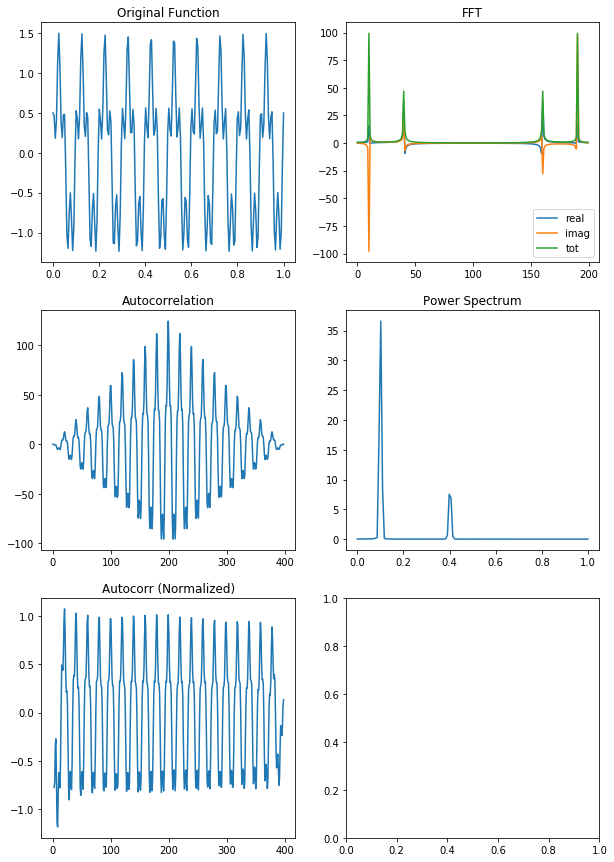

In [17]:
def autocorr(x, pearson=False):
    ac = np.correlate(x, x, mode="full" )
    if not pearson:
        return ac
    else:
        n = len(x)
        var = np.var(x)
        idxs = n - np.abs(np.arange(2*n - 1) - n - 1)
        return ac / var / idxs

# Compute FFT
x = np.linspace(0, 1, 200)
y = np.sin(2 * np.pi * 10 * x)
y += 0.5* np.cos(2 * np.pi * 40 * x)
fft = np.fft.fft(y)

# Calculate Autocorrelation
auto1 = autocorr(y)
auto2 = autocorr(y, pearson=True)

# Power spectral density
pxx1,f1 = plt.mlab.psd(y)

fig, ax = plt.subplots(ncols=2, nrows=3, figsize=(10,15))
ax[0][0].set_title("Original Function")
ax[0][1].set_title("FFT")
ax[1][0].set_title("Autocorrelation")
ax[1][1].set_title("Power Spectrum")
ax[2][0].set_title("Autocorr (Normalized)")
ax[0][0].plot(x,y)
ax[0][1].plot(np.real(fft), label="real")
ax[0][1].plot(np.imag(fft), label="imag")
ax[0][1].plot(np.abs(fft), label="tot")
ax[0][1].legend()
ax[1][0].plot(auto1)
ax[1][1].plot(f1, pxx1)
ax[2][0].plot(auto2)

plt.show()